# 1. Imports

In [1]:
# Import the plotting library
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import requests

import yfinance as yf

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import StandardScaler, MinMaxScaler

https://www.tensorflow.org/tutorials/structured_data/time_series?hl=ru#recurrent_neural_network

# 2. Load source data

In [9]:
# Get the data for the stock S&P 500, NASDAQ, DAX
data_s_p_500 = yf.download('^GSPC','2018-01-01','2023-01-01')
data_nasdaq = yf.download('^IXIC','2018-01-01','2023-01-01')
data_dax = yf.download('^GDAXI','2018-01-01','2023-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
# Normalization
data_s_p_500 = data_s_p_500['Adj Close']
data_nasdaq = data_nasdaq['Adj Close']
data_dax = data_dax['Adj Close']

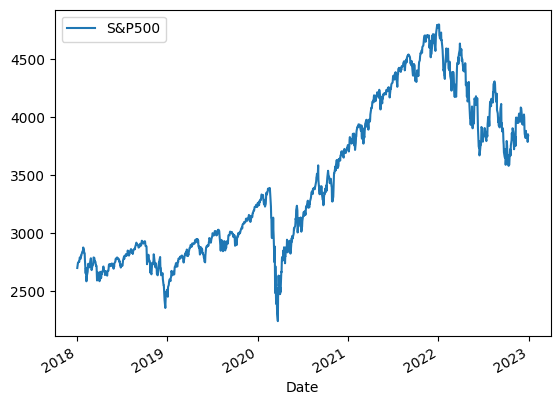

In [11]:
data_s_p_500.plot(label='S&P500')
plt.legend()
plt.show()


In [12]:
# Merge to DataFrame
df = pd.DataFrame({'s_p_500': data_s_p_500, 
                   'nas': data_nasdaq, 
                   'dax': data_dax.values[:1259]})

In [13]:
df.head()

,s_p_500,nas,dax
Date,,,
2018-01-02 00:00:00-05:00,2695.810059,7006.899902,12871.389648
2018-01-03 00:00:00-05:00,2713.060059,7065.529785,12978.209961
2018-01-04 00:00:00-05:00,2723.989990,7077.910156,13167.889648
2018-01-05 00:00:00-05:00,2743.149902,7136.560059,13319.639648
2018-01-08 00:00:00-05:00,2747.709961,7157.390137,13367.780273


In [75]:
df.index.year.unique()

Int64Index([2018, 2019, 2020, 2021, 2022], dtype='int64', name='Date')

In [83]:
df.shape

(1259, 3)

In [76]:
train = df.loc[df.index.year < 2022]

In [77]:
train.shape

(1008, 3)

In [84]:
df.loc[df.index.year == 2022].shape

(251, 3)

In [85]:
1008+250

1259

In [86]:
x_train = np.zeros([648, 360])
y_train = np.zeros(648)

x_test = np.zeros([250, 360])
y_test = np.zeros(250)

In [87]:
for i in range(648):
    x_train[i] = df.iloc[i:i+360]['s_p_500'].values
    y_train[i] = (x_train[i, -2] - x_train[i, -1]) < 0
    
    
for j in range(250):
    x_test[j] = df.iloc[j+648:j+1008]['s_p_500'].values
    y_test[j] = (x_test[j, -2] - x_test[j, -1]) < 0

In [88]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [89]:
num_classes = len(np.unique(y_train))

In [90]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [91]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])

In [92]:
epochs = 200
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/200


2023-01-26 22:17:37.881782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 0.7150 - sparse_categorical_accuracy: 0.5270

2023-01-26 22:17:39.333707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 2s 71ms/step - loss: 0.7150 - sparse_categorical_accuracy: 0.5270 - val_loss: 18.0950 - val_sparse_categorical_accuracy: 0.4077 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6905 - sparse_categorical_accuracy: 0.5463 - val_loss: 4.3174 - val_sparse_categorical_accuracy: 0.5923 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - 0s 17ms/step - loss: 0.6886 - sparse_categorical_accuracy: 0.5463 - val_loss: 2.7397 - val_sparse_categorical_accuracy: 0.5923 - lr: 0.0010
Epoch 4/200
17/17 [==============================] - 0s 17ms/step - loss: 0.6848 - sparse_categorical_accuracy: 0.5618 - val_loss: 4.1619 - val_sparse_categorical_accuracy: 0.5923 - lr: 0.0010
Epoch 5/200
17/17 [==============================] - 0s 17ms/step - loss: 0.6845 - sparse_categorical_accuracy: 0.5734 - val_loss: 1.2534 - val_sparse_categorical_accuracy: 0.5923 - lr: 0.0010
Epoch 6/200
17/17 [===========================

17/17 [==============================] - 0s 16ms/step - loss: 0.6757 - sparse_categorical_accuracy: 0.5618 - val_loss: 0.9422 - val_sparse_categorical_accuracy: 0.4077 - lr: 5.0000e-04
Epoch 44/200
17/17 [==============================] - 0s 16ms/step - loss: 0.6734 - sparse_categorical_accuracy: 0.5734 - val_loss: 1.5620 - val_sparse_categorical_accuracy: 0.4077 - lr: 5.0000e-04
Epoch 45/200
17/17 [==============================] - 0s 15ms/step - loss: 0.6768 - sparse_categorical_accuracy: 0.5792 - val_loss: 0.8826 - val_sparse_categorical_accuracy: 0.4077 - lr: 5.0000e-04
Epoch 46/200
17/17 [==============================] - 0s 15ms/step - loss: 0.6712 - sparse_categorical_accuracy: 0.5714 - val_loss: 0.6919 - val_sparse_categorical_accuracy: 0.4923 - lr: 5.0000e-04
Epoch 47/200
17/17 [==============================] - 0s 15ms/step - loss: 0.6750 - sparse_categorical_accuracy: 0.5753 - val_loss: 1.2943 - val_sparse_categorical_accuracy: 0.5923 - lr: 5.0000e-04
Epoch 48/200
17/17 [===

In [93]:
predictions = model.predict(x_test)

8/8 [==============================] - 0s 7ms/step


2023-01-26 22:17:58.012735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [94]:
y_test.shape

(250,)

In [109]:
y_pred = predictions[:, 0]

In [110]:
y_test[:5]

array([0., 1., 0., 0., 0.])

In [118]:
y_pred = y_pred<0.5
y_pred[:5]

array([ True,  True,  True,  True,  True])

In [112]:
y_test[:5] == y_pred[:5]

array([ True, False,  True,  True,  True])

In [122]:
np.unique(y_pred)

array([ True])

In [116]:
d_2022 = df.loc[df.index.year == 2022, 's_p_500']
d_2022.head()

Date
2022-01-03 00:00:00-05:00    4796.560059
2022-01-04 00:00:00-05:00    4793.540039
2022-01-05 00:00:00-05:00    4700.580078
2022-01-06 00:00:00-05:00    4696.049805
2022-01-07 00:00:00-05:00    4677.029785
Name: s_p_500, dtype: float64

In [120]:
start_m = 1000
finish_m = 0
day_m = start_m

for i in range(250):
    day_k = day_m / d_2022.iloc[i]

    if y_pred[i]:
        day_m = day_m
    else:
        if d_2022.iloc[i]['Open'] * 1.1 < d_2022.iloc[i]['High']:
            day_m = day_k * 1.1
        else:
            day_m = day_k * d_2022.iloc[i]['Close']

    finish_m = day_m

print(finish_m)

1000
